# Cleaning data with PySpark

## Start spark context

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)
print(sc)
print(sqlContext)

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import types as stypes
from pyspark.sql.functions import udf
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL cleaning data") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scp
import pandas as pd
import random
random.seed()

## Posts import

In [5]:
fields = [
    stypes.StructField("Id", stypes.IntegerType(), True),\
    stypes.StructField("PostTypeId", stypes.IntegerType(), True),\
    stypes.StructField("AcceptedAnswerId", stypes.IntegerType(), True),\
    stypes.StructField("ParentId", stypes.IntegerType(), True),\
    stypes.StructField("CreationDate", stypes.StringType(), True),\
    stypes.StructField("DeletionDate", stypes.StringType(), True),\
    stypes.StructField("Score", stypes.IntegerType(), True),\
    stypes.StructField("ViewCount", stypes.IntegerType(), True),\
    stypes.StructField("Body", stypes.StringType(), True),\
    stypes.StructField("OwnerUserId", stypes.IntegerType(), True),\
    stypes.StructField("OwnerDisplayName", stypes.StringType(), True),\
    stypes.StructField("LastEditorUserId", stypes.IntegerType(), True),\
    stypes.StructField("LastEditorDisplayName", stypes.StringType(), True),\
    stypes.StructField("LastEditDate", stypes.StringType(), True),\
    stypes.StructField("LastActivityDate", stypes.StringType(), True),\
    stypes.StructField("Title", stypes.StringType(), True),\
    stypes.StructField("Tags", stypes.StringType(), True),\
    stypes.StructField("AnswerCount", stypes.IntegerType(), True),\
    stypes.StructField("CommentCount", stypes.IntegerType(), True),\
    stypes.StructField("FavoriteCount", stypes.IntegerType(), True),\
    stypes.StructField("ClosedDate", stypes.StringType(), True),\
    stypes.StructField("CommunityOwnedDate", stypes.StringType(), True)
]
customSchema = stypes.StructType(fields)
posts = sqlContext.read\
.format('com.databricks.spark.csv')\
.load("file:///Users/Mat/Google_Drive/tfm/analysis/data/posts_csv",\
      schema=customSchema)

In [6]:
#posts.toPandas()

In [7]:
reduced_posts = posts.drop('ParentId','Score','ViewCount','Body','OwnerDisplayName',\
                         'LastEditorUserId','LastEditorDisplayName','LastEditDate','LastActivityDate','AnswerCount',\
                         'CommentCount','FavoriteCount','CommunityOwnedDate','DeletionDate')

In [8]:
#reduced_posts.describe().toPandas()

## Questions import

### UDF to transform questions columns

In [9]:
parse_time_udf = udf(lambda x: \
    float((datetime.strptime(x.split(".")[0], '%Y-%m-%dT%H:%M:%S') - datetime.min).total_seconds()),\
    stypes.FloatType()
)

parse_time_check_udf = udf(lambda x:\
    float((datetime.strptime(x.split(".")[0], '%Y-%m-%dT%H:%M:%S') - datetime.min).total_seconds())\
    if x is not None else None,\
    stypes.FloatType()
)

tag_counter_udf = udf(lambda x:\
    float(len([tag.split("&lt;")[1] for tag in x.split("&gt;")[0:-1]])),\
    stypes.FloatType()
)

title_length_udf = udf(lambda x:\
    float(len(x)),\
    stypes.FloatType()
)

In [10]:
questions = reduced_posts.filter(reduced_posts.PostTypeId == 1)\
.drop("PostTypeId")
questions = questions.\
withColumn("ParsedCreationDate", parse_time_udf(questions.CreationDate)).\
withColumn("ParsedClosedDate", parse_time_check_udf(questions.ClosedDate)).\
withColumn("TagCount", tag_counter_udf(questions.Tags)).\
withColumn("TitleLength", title_length_udf(questions.Title)).\
withColumnRenamed("OwnerUserId","PosterOwnerUserId").\
drop("CreationDate","ClosedDate", "Tags", "Title")

In [11]:
#questions.toPandas()

In [12]:
#questions.describe().toPandas()

In [13]:
min_time = questions.select(questions.ParsedCreationDate).rdd.min()[0]
print(min_time)

63430377472.0


# Answers import

In [14]:
answers = reduced_posts.filter(reduced_posts.PostTypeId == 2)\
.drop("AcceptedAnswerId", "Title", "Tags", "ClosedDate","PostTypeId")
answers = answers.withColumn("AnsParsedCreationDate", parse_time_udf(answers.CreationDate)).drop(answers.CreationDate)

In [15]:
#answers.describe().toPandas()

In [16]:
answers.registerTempTable("answers")
questions.registerTempTable("questions")

In [17]:
accepted_answers = sqlContext\
.sql("SELECT * FROM answers WHERE answers.Id IN (SELECT AcceptedAnswerId FROM questions)")\

accepted_answers = accepted_answers\
.withColumnRenamed("Id", "AnswerId")\

In [18]:
#accepted_answers.toPandas()

In [19]:
max_time = accepted_answers.select(accepted_answers.AnsParsedCreationDate).rdd.max()[0]
print(max_time)

63592824832.0


## Users import

In [20]:
fields = [
    stypes.StructField("Id", stypes.IntegerType(), True),\
    stypes.StructField("Reputation", stypes.FloatType(), True),\
    stypes.StructField("CreationDate", stypes.StringType(), True),\
    stypes.StructField("DisplayName", stypes.StringType(), True),\
    stypes.StructField("LastAccessDate", stypes.StringType(), True),\
    stypes.StructField("WebsiteUrl", stypes.StringType(), True),\
    stypes.StructField("Location", stypes.StringType(), True),\
    stypes.StructField("AboutMe", stypes.StringType(), True),\
    stypes.StructField("Views", stypes.IntegerType(), True),\
    stypes.StructField("UpVotes", stypes.IntegerType(), True),\
    stypes.StructField("DownVotes", stypes.IntegerType(), True),\
    stypes.StructField("Age", stypes.FloatType(), True),\
    stypes.StructField("AccountId", stypes.IntegerType(), True),\
]
customSchema = stypes.StructType(fields)
users = sqlContext.read\
.format('com.databricks.spark.csv')\
.load("file:///Users/Mat/Google_Drive/tfm/analysis/data/users_csv/part-00000",\
      schema=customSchema)
users.describe().toPandas()
users = users.drop("CreationDate","DisplayName","LastAccessDate","WebsiteUrl","Location","AboutMe","Views","UpVotes",\
                   "DownVotes","AccountId")
users = users.withColumnRenamed("Id","UserId").withColumnRenamed("Reputation","UserReputation")

In [21]:
users.describe().toPandas()

,summary,UserId,UserReputation,Age
0,count,43360,43360,12901
1,mean,31417.359202029522,171.96042435424354,33.28548174560112
2,stddev,19202.403149027137,2012.982474680336,10.22403146691696
3,min,-1,1.0,14.0
4,max,62923,198942.0,96.0


# Join for final dataframe

### First join answers with users

In [22]:
questions_with_users = questions.join(users, questions.PosterOwnerUserId == users.UserId, "left").\
withColumnRenamed("Age","PosterAge").withColumnRenamed("UserReputation","PosterReputation").\
drop("PosterOwnerUserId","UserId")
join_df = questions_with_users.join(accepted_answers, accepted_answers.AnswerId == questions.AcceptedAnswerId, 'full')
join_df = join_df.join(users, join_df.OwnerUserId == users.UserId, "left").\
drop("AcceptedAnswerId","UserId","OwnerUserId", "AnswerId", "Id")

In [23]:
#join_df.toPandas()

In [24]:
join_df.describe().toPandas()

,summary,ParsedCreationDate,ParsedClosedDate,TagCount,TitleLength,PosterReputation,PosterAge,AnsParsedCreationDate,UserReputation,Age
0,count,29301,2511,29301,29301,28727,12214,17917,17208,7763
1,mean,6.3530990516967476E10,6.35485619340693E10,2.0557660148117813,59.35329852223474,12918.052981515648,34.68536106107745,6.352499363107306E10,49932.78074151558,37.24591008630684
2,stddev,4.504117517012715E7,3.532019377350662E7,0.9919622077292334,22.55610271635549,33500.48405203392,11.211497949946038,4.6620306413311735E7,63437.14410370897,9.559868164116324
3,min,6.3430377E10,6.3431139E10,1.0,15.0,1.0,14.0,6.3430377E10,1.0,14.0
4,max,6.3592829E10,6.3592829E10,5.0,168.0,198942.0,96.0,6.3592825E10,198942.0,96.0


## Final formatting and adding censored variable and final time

In [25]:
def final_time(ParsedCreationDate, ParsedClosedDate, AnsParsedCreationDate):

    if(AnsParsedCreationDate):
        return AnsParsedCreationDate-ParsedCreationDate
    elif(ParsedClosedDate):
        return ParsedClosedDate-ParsedCreationDate
    else:
        return max_time-ParsedCreationDate

final_time_udf = udf(final_time, stypes.FloatType())

def censoring_status(ParsedCreationDate, ParsedClosedDate, AnsParsedCreationDate):
    
    if(AnsParsedCreationDate):
        return float(1)
    elif(ParsedClosedDate):
        return float(0)
    else:
        return float(0)
    
censoring_status_udf = udf(censoring_status, stypes.FloatType())

In [26]:
final_df = join_df.\
withColumn("FinalTime",\
final_time_udf(join_df.ParsedCreationDate, join_df.ParsedClosedDate, join_df.AnsParsedCreationDate)).\
withColumn("CensoringStatus",\
censoring_status_udf(join_df.ParsedCreationDate, join_df.ParsedClosedDate, join_df.AnsParsedCreationDate)).\
drop("ParsedCreationDate", "ParsedClosedDate", "AnsParsedCreationDate")

In [27]:
final_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,UserReputation,Age,FinalTime,CensoringStatus
0,count,29301,29301,28727,12214,17208,7763,29301,29301
1,mean,2.0557660148117813,59.35329852223474,12918.052981515648,34.68536106107745,49932.78074151558,37.24591008630684,1.7990164601617694E7,0.6114808368315074
2,stddev,0.9919622077292334,22.55610271635549,33500.48405203392,11.211497949946038,63437.14410370897,9.559868164116324,3.325815829370682E7,0.48742192326517086
3,min,1.0,15.0,1.0,14.0,1.0,14.0,-5.6172544E7,0.0
4,max,5.0,168.0,198942.0,96.0,198942.0,96.0,1.62443264E8,1.0



## Filtering invalid results

In [28]:
final_filtered_df = final_df.filter(final_df.FinalTime > float(0))

In [29]:
final_filtered_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,UserReputation,Age,FinalTime,CensoringStatus
0,count,24009,24009,23517,9683,12425,5554,24009,24009
1,mean,2.058894581198717,59.9233204215086,12649.858017604287,34.83228338324899,46809.372796780684,37.44382427079582,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,33794.18142702922,11.252678205914636,62553.06355062486,9.477650292365588,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,198942.0,96.0,1.62443264E8,1.0


In [30]:
#final_filtered_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","UserReputation","Age")\
#.toPandas().to_csv("/Users/Mat/Desktop/final_df")

In [31]:
#final_filtered_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","UserReputation","Age").\
#write.csv("/Users/Mat/Desktop/final_df_float")

## Dealing with missing values

Age and UserReputation are data related to the user that posted the answer, and so there are a lot of missing values, as there are numerous not answered questions (censored data). Therefore these features are omited from the survival analysis

In [32]:
final_reduced_df = final_filtered_df.drop("Age","UserReputation")
final_reduced_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
0,count,24009,24009,23517,9683,24009,24009
1,mean,2.058894581198717,59.9233204215086,12649.858017604287,34.83228338324899,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,33794.18142702922,11.252678205914636,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,1.62443264E8,1.0


### UDFs to fill NaNs

### Poster Reputation
The feature PosterReputation does not follow any specific distribution, so missing data is imputed randomly.

In [33]:
min_reputation = final_reduced_df.select("PosterReputation").\
where(final_reduced_df.PosterReputation.isNotNull()).rdd.min()[0]
max_reputation = final_reduced_df.select("PosterReputation").\
where(final_reduced_df.PosterReputation.isNotNull()).rdd.max()[0]

In [34]:
final_red_pr_df = final_reduced_df.fillna(random.randint(min_reputation, max_reputation), subset=["PosterReputation"])

In [35]:
final_red_pr_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
0,count,24009,24009,24009,9683,24009,24009
1,mean,2.058894581198717,59.9233204215086,13837.86192677746,34.83228338324899,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,34439.89428473207,11.252678205914636,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,1.62443264E8,1.0


### Poster Age
The feature PosterAge misses the majority of the data, having only around 40% of the total data. To fill the missing values of this feature, MICE technique has been compared with KNN method, both contained in the python package fancyimpute. 

In [36]:
import fancyimpute

In [37]:
from fancyimpute import MICE, SoftImpute, KNN
solver = SoftImpute(verbose=False)
#backup the column names
column_names=final_red_pr_df.columns

In [38]:
final_matrix = final_red_pr_df.toPandas().as_matrix()
solver = MICE(verbose=0)
final_matrix_mice = solver.complete(final_matrix)

In [39]:
final_matrix_knn = KNN(k=3).complete(final_matrix)

Imputing row 1/24009 with 0 missing, elapsed time: 84.426
Imputing row 101/24009 with 0 missing, elapsed time: 84.441
Imputing row 201/24009 with 0 missing, elapsed time: 84.450
Imputing row 301/24009 with 1 missing, elapsed time: 84.461
Imputing row 401/24009 with 0 missing, elapsed time: 84.472
Imputing row 501/24009 with 1 missing, elapsed time: 84.480
Imputing row 601/24009 with 0 missing, elapsed time: 84.489
Imputing row 701/24009 with 1 missing, elapsed time: 84.498
Imputing row 801/24009 with 0 missing, elapsed time: 84.507
Imputing row 901/24009 with 0 missing, elapsed time: 84.516
Imputing row 1001/24009 with 1 missing, elapsed time: 84.524
Imputing row 1101/24009 with 0 missing, elapsed time: 84.533
Imputing row 1201/24009 with 1 missing, elapsed time: 84.542
Imputing row 1301/24009 with 0 missing, elapsed time: 84.552
Imputing row 1401/24009 with 0 missing, elapsed time: 84.563
Imputing row 1501/24009 with 0 missing, elapsed time: 84.574
Imputing row 1601/24009 with 1 missi

Imputing row 15001/24009 with 0 missing, elapsed time: 86.535
Imputing row 15101/24009 with 0 missing, elapsed time: 86.545
Imputing row 15201/24009 with 0 missing, elapsed time: 86.554
Imputing row 15301/24009 with 1 missing, elapsed time: 86.563
Imputing row 15401/24009 with 1 missing, elapsed time: 86.571
Imputing row 15501/24009 with 1 missing, elapsed time: 86.581
Imputing row 15601/24009 with 1 missing, elapsed time: 86.590
Imputing row 15701/24009 with 1 missing, elapsed time: 86.601
Imputing row 15801/24009 with 0 missing, elapsed time: 86.610
Imputing row 15901/24009 with 1 missing, elapsed time: 86.620
Imputing row 16001/24009 with 1 missing, elapsed time: 86.632
Imputing row 16101/24009 with 0 missing, elapsed time: 86.644
Imputing row 16201/24009 with 0 missing, elapsed time: 86.653
Imputing row 16301/24009 with 1 missing, elapsed time: 86.661
Imputing row 16401/24009 with 1 missing, elapsed time: 86.671
Imputing row 16501/24009 with 1 missing, elapsed time: 86.678
Imputing

#### Comparison of the samples generated by MICE method and KNN

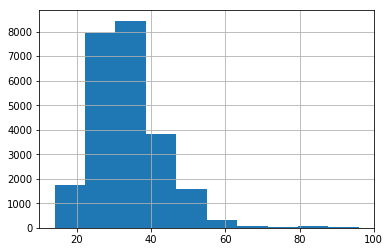

In [40]:
pd.DataFrame(final_matrix_knn, columns = [x for x in list(column_names)]).PosterAge.hist()

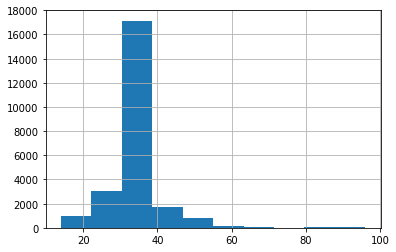

In [41]:
pd.DataFrame(final_matrix_mice, columns = [x for x in list(column_names)]).PosterAge.hist()

In [42]:
pd_final_mice = pd.DataFrame(final_matrix_knn, columns = [x for x in list(column_names)])
pd_final_knn = pd.DataFrame(final_matrix_knn, columns = [x for x in list(column_names)])

In [43]:
pd_final_mice.describe()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
count,24009.000000,24009.000000,24009.000000,24009.000000,2.400900e+04,24009.000000
mean,2.058895,59.923320,13837.861927,34.053919,2.195890e+07,0.538715
std,0.992615,22.637822,34439.894285,9.755022,3.553241e+07,0.498509
min,1.000000,15.000000,1.000000,13.999999,4.096000e+03,0.000000
25%,1.000000,43.000000,109.000000,27.182650,8.192000e+03,0.000000
50%,2.000000,57.000000,803.000000,32.640093,2.088960e+05,1.000000
75%,3.000000,73.000000,8117.000000,38.360211,3.276390e+07,1.000000
max,5.000000,168.000000,198942.000000,96.000000,1.624433e+08,1.000000


In [44]:
pd_final_knn.describe()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
count,24009.000000,24009.000000,24009.000000,24009.000000,2.400900e+04,24009.000000
mean,2.058895,59.923320,13837.861927,34.053919,2.195890e+07,0.538715
std,0.992615,22.637822,34439.894285,9.755022,3.553241e+07,0.498509
min,1.000000,15.000000,1.000000,13.999999,4.096000e+03,0.000000
25%,1.000000,43.000000,109.000000,27.182650,8.192000e+03,0.000000
50%,2.000000,57.000000,803.000000,32.640093,2.088960e+05,1.000000
75%,3.000000,73.000000,8117.000000,38.360211,3.276390e+07,1.000000
max,5.000000,168.000000,198942.000000,96.000000,1.624433e+08,1.000000


Choosing knn adjust as it is more similar to the previous data

In [45]:
final_knn_df = sqlContext.createDataFrame(pd_final_knn)

# Exploratory analysis

In [55]:
fig_size = []
fig_size.append(15)
fig_size.append(15)
plt.rcParams["figure.figsize"] = fig_size

### Correlation and covariance matrixes

In [78]:
final_knn_df.drop("CensoringStatus").toPandas().corr()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime
TagCount,1.000000,0.060511,-0.015367,0.007575,-0.018741
TitleLength,0.060511,1.000000,-0.003752,0.058853,0.071873
PosterReputation,-0.015367,-0.003752,1.000000,0.210137,0.002616
PosterAge,0.007575,0.058853,0.210137,1.000000,0.051550
FinalTime,-0.018741,0.071873,0.002616,0.051550,1.000000


Light correlation between CensoringStatus and PosterReputation, also between CensoringStatus and FinalTime

In [77]:
#final_knn_df.drop("CensoringStatus").toPandas().cov()

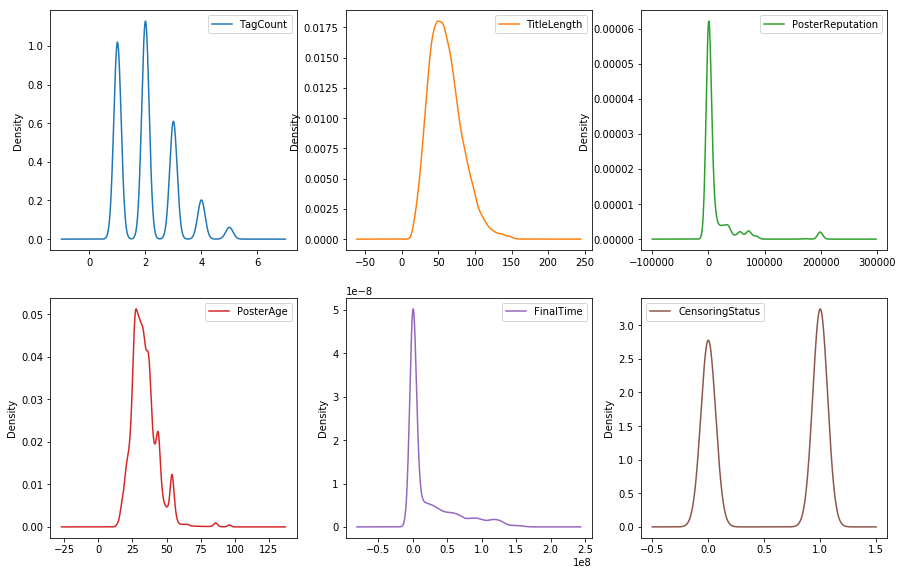

In [68]:
final_knn_df.toPandas().plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.savefig('/Users/Mat/github/survival_analysis/paper/images/variables_density_distribution.png',\
            format='png', dpi=300)

Full correlation between numerical variables

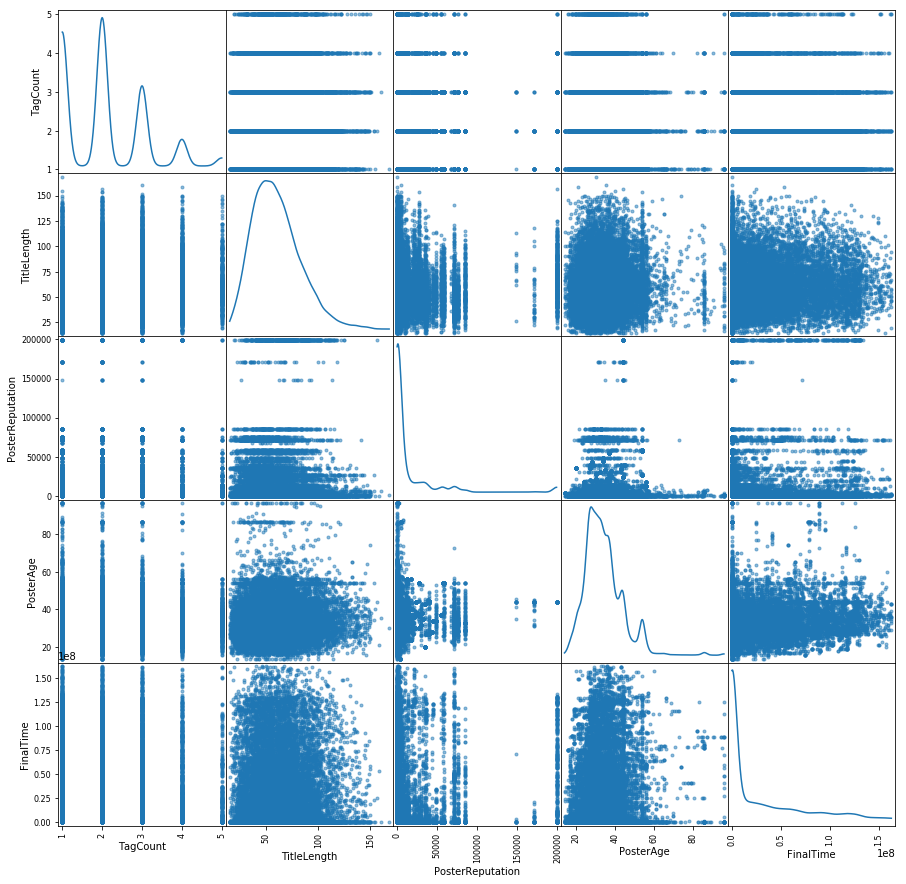

In [76]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(final_knn_df.drop("CensoringStatus").toPandas(), diagonal='kde')
plt.savefig('/Users/Mat/github/survival_analysis/paper/images/correlation_density.png', format='png', dpi=200)

Correlation on uncensored data

In [80]:
final_knn_df.where(final_knn_df.CensoringStatus != 0.0).drop("CensoringStatus").toPandas().corr()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime
TagCount,1.000000,0.059104,-0.016865,-0.005132,0.014818
TitleLength,0.059104,1.000000,0.006583,0.075735,0.026250
PosterReputation,-0.016865,0.006583,1.000000,0.233297,0.118113
PosterAge,-0.005132,0.075735,0.233297,1.000000,0.050672
FinalTime,0.014818,0.026250,0.118113,0.050672,1.000000


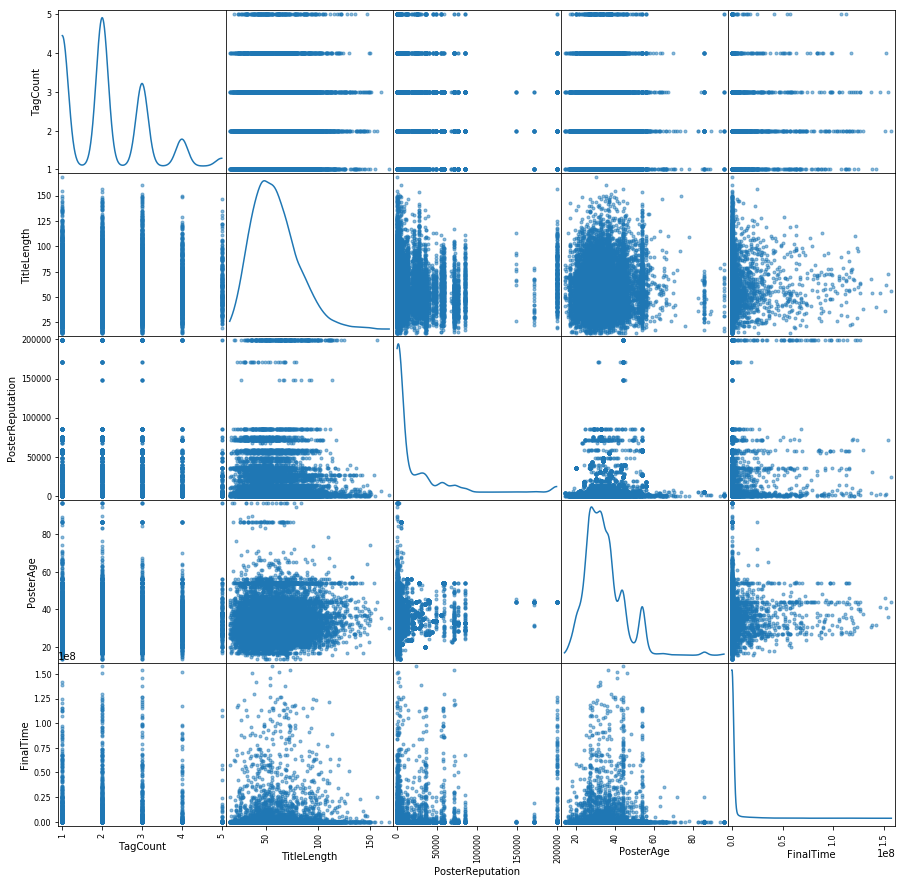

In [79]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(final_knn_df.where(final_knn_df.CensoringStatus != 0.0).drop("CensoringStatus").toPandas(),\
diagonal='kde')
plt.savefig('/Users/Mat/github/survival_analysis/paper/images/correlation_uncensored_density.png',\
format='png', dpi=200)

Correlation on censored data

In [81]:
final_knn_df.where(final_knn_df.CensoringStatus != 1.0).drop("CensoringStatus").toPandas().corr()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime
TagCount,1.000000,0.064785,-0.017969,0.021824,-0.021825
TitleLength,0.064785,1.000000,0.000686,0.045365,0.049065
PosterReputation,-0.017969,0.000686,1.000000,0.172690,0.099369
PosterAge,0.021824,0.045365,0.172690,1.000000,0.125672
FinalTime,-0.021825,0.049065,0.099369,0.125672,1.000000


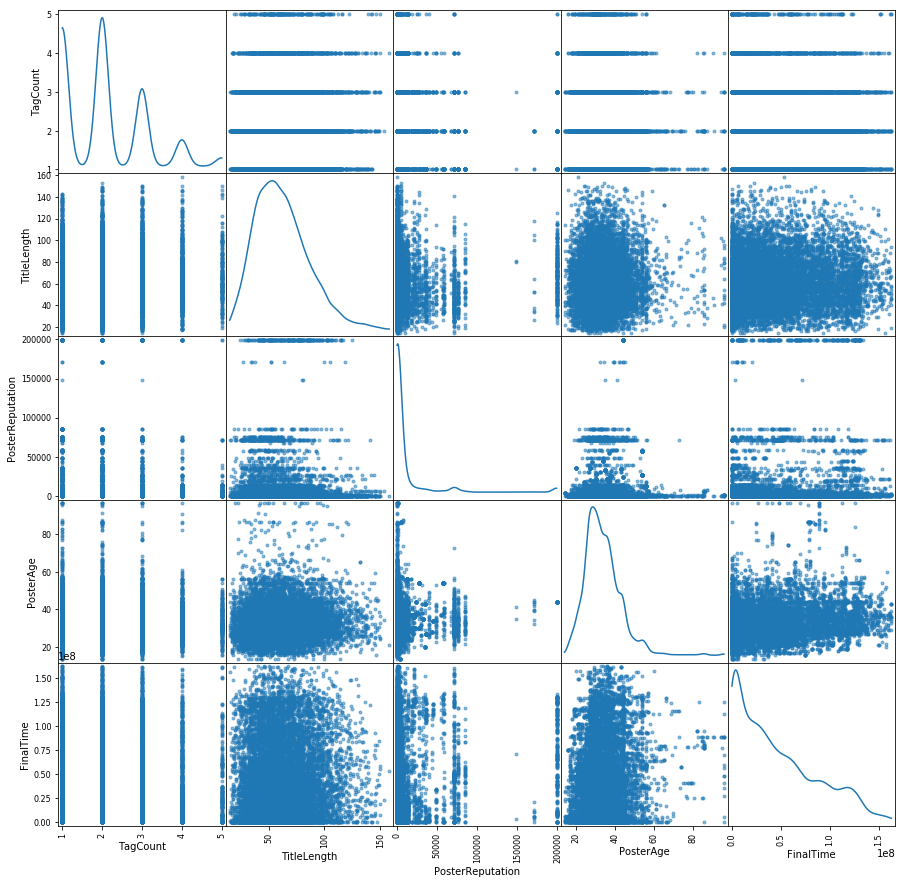

In [82]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(final_knn_df.where(final_knn_df.CensoringStatus != 1.0).drop("CensoringStatus").toPandas(),\
diagonal='kde')
plt.savefig('/Users/Mat/github/survival_analysis/paper/images/correlation_censored_density.png',\
format='png', dpi=200)

## Data output to file

In [ ]:
#final_knn_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","PosterReputation","PosterAge").toPandas()

In [ ]:
#final_knn_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","PosterReputation","PosterAge").\
#write.csv("/Users/Mat/Desktop/final_df_fill")

## Data grouping for Kaplan Meier